In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Flatten
import pandas as pd
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from datetime import timedelta
from keras.models import load_model

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

# Pengumpulan Data 

In [3]:
# Data Bank
file = 'stock_dataset/BBRI.JK.csv'
df = pd.read_csv(file, parse_dates = True,index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2305.0,2345.0,2305.0,2330.0,1924.688843,45155000.0
2015-01-05,2320.0,2340.0,2315.0,2320.0,1916.428589,49569000.0
2015-01-06,2310.0,2325.0,2300.0,2305.0,1904.037964,65091500.0
2015-01-07,2320.0,2355.0,2315.0,2355.0,1945.340210,146164500.0
2015-01-08,2360.0,2395.0,2360.0,2395.0,1978.382202,146663500.0
...,...,...,...,...,...,...
2021-12-15,4150.0,4230.0,4140.0,4200.0,4200.000000,124522800.0
2021-12-16,4220.0,4220.0,4120.0,4140.0,4140.000000,136646600.0
2021-12-17,4090.0,4140.0,4090.0,4110.0,4110.000000,153165400.0


In [4]:
# Data Kurs Rupiah
file = 'stock_dataset/Kurs_Transaksi_USD.csv'
df1 = pd.read_csv(file, parse_dates = True,index_col=0)
df1

,Nilai,Kurs Jual,Kurs Beli
Date,,,
2015-01-02,1,12536.00,12412.00
2015-01-05,1,12652.00,12526.00
2015-01-06,1,12721.00,12595.00
2015-01-07,1,12796.00,12668.00
2015-01-08,1,12795.00,12667.00
...,...,...,...
2021-12-15,1,14419.74,14276.26
2021-12-16,1,14408.69,14265.32
2021-12-17,1,14414.72,14271.29


# Preprocessing Data

In [5]:
# menggabungkan data kurs dan data harga saham 
data = pd.merge_asof(df, df1, on='Date')
data = data.rename(columns = {'Adj Close' : 'adj_close', 'Kurs Jual' : 'kurs_jual', 'Kurs Beli' : 'kurs_beli'})
dataset = data.set_index('Date')
dataset

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2015-01-02,2305.0,2345.0,2305.0,2330.0,1924.688843,45155000.0,1,12536.00,12412.00
2015-01-05,2320.0,2340.0,2315.0,2320.0,1916.428589,49569000.0,1,12652.00,12526.00
2015-01-06,2310.0,2325.0,2300.0,2305.0,1904.037964,65091500.0,1,12721.00,12595.00
2015-01-07,2320.0,2355.0,2315.0,2355.0,1945.340210,146164500.0,1,12796.00,12668.00
2015-01-08,2360.0,2395.0,2360.0,2395.0,1978.382202,146663500.0,1,12795.00,12667.00
...,...,...,...,...,...,...,...,...,...
2021-12-15,4150.0,4230.0,4140.0,4200.0,4200.000000,124522800.0,1,14419.74,14276.26
2021-12-16,4220.0,4220.0,4120.0,4140.0,4140.000000,136646600.0,1,14408.69,14265.32
2021-12-17,4090.0,4140.0,4090.0,4110.0,4110.000000,153165400.0,1,14414.72,14271.29


In [6]:
# Periksa nilai yang hilang
data.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
adj_close    1
Volume       1
Nilai        0
kurs_jual    0
kurs_beli    0
dtype: int64

In [7]:
nul_data = pd.isnull(dataset['Close']) 
dataset[nul_data]

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2019-06-19,NaN,NaN,NaN,NaN,NaN,NaN,1,14342.0,14200.0


In [8]:
# Ganti nilai yang hilang dengan interpolasi
dataset = dataset.fillna(dataset.interpolate(method='linear'))
dataset.to_csv("stock_dataset/data_cleaning_br.csv", index=True)
dataset.loc[["2019-06-19"]]

,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
Date,,,,,,,,,
2019-06-19,4255.0,4295.0,4230.0,4285.0,4050.145874,133028950.0,1,14342.0,14200.0


In [9]:
dataset = dataset.reset_index()
dataset

,Date,Open,High,Low,Close,adj_close,Volume,Nilai,kurs_jual,kurs_beli
0,2015-01-02,2305.0,2345.0,2305.0,2330.0,1924.688843,45155000.0,1,12536.00,12412.00
1,2015-01-05,2320.0,2340.0,2315.0,2320.0,1916.428589,49569000.0,1,12652.00,12526.00
2,2015-01-06,2310.0,2325.0,2300.0,2305.0,1904.037964,65091500.0,1,12721.00,12595.00
3,2015-01-07,2320.0,2355.0,2315.0,2355.0,1945.340210,146164500.0,1,12796.00,12668.00
4,2015-01-08,2360.0,2395.0,2360.0,2395.0,1978.382202,146663500.0,1,12795.00,12667.00
...,...,...,...,...,...,...,...,...,...,...
1741,2021-12-15,4150.0,4230.0,4140.0,4200.0,4200.000000,124522800.0,1,14419.74,14276.26
1742,2021-12-16,4220.0,4220.0,4120.0,4140.0,4140.000000,136646600.0,1,14408.69,14265.32
1743,2021-12-17,4090.0,4140.0,4090.0,4110.0,4110.000000,153165400.0,1,14414.72,14271.29
1744,2021-12-20,4070.0,4130.0,4060.0,4120.0,4120.000000,89198900.0,1,14414.72,14271.29


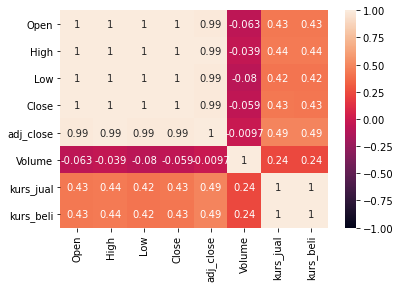

In [10]:
# Korelasi Data
dataset.drop(['Nilai'], axis=1, inplace=True)
matrix = dataset.corr(method='pearson')
ax = sns.heatmap(matrix, vmax=1, vmin=-1, annot=True)
ax.figure.savefig('M:/Metopen/save/korelasi_br.jpg')

In [11]:
# pemilihan fitur
df = read_csv('stock_dataset/data_cleaning_br.csv', header=0, index_col=0)
df.drop(['Volume', 'Nilai', 'kurs_jual', 'kurs_beli'], axis=1, inplace=True)
df

,Open,High,Low,Close,adj_close
Date,,,,,
2015-01-02,2305.0,2345.0,2305.0,2330.0,1924.688843
2015-01-05,2320.0,2340.0,2315.0,2320.0,1916.428589
2015-01-06,2310.0,2325.0,2300.0,2305.0,1904.037964
2015-01-07,2320.0,2355.0,2315.0,2355.0,1945.340210
2015-01-08,2360.0,2395.0,2360.0,2395.0,1978.382202
...,...,...,...,...,...
2021-12-15,4150.0,4230.0,4140.0,4200.0,4200.000000
2021-12-16,4220.0,4220.0,4120.0,4140.0,4140.000000
2021-12-17,4090.0,4140.0,4090.0,4110.0,4110.000000


In [12]:
# pindah kolom baris close ke baris pertama
last_col = df.pop('Close')
type(last_col)
pd.core.series.Series
df.insert(loc=0, column = 'Close', value = last_col)
df

,Close,Open,High,Low,adj_close
Date,,,,,
2015-01-02,2330.0,2305.0,2345.0,2305.0,1924.688843
2015-01-05,2320.0,2320.0,2340.0,2315.0,1916.428589
2015-01-06,2305.0,2310.0,2325.0,2300.0,1904.037964
2015-01-07,2355.0,2320.0,2355.0,2315.0,1945.340210
2015-01-08,2395.0,2360.0,2395.0,2360.0,1978.382202
...,...,...,...,...,...
2021-12-15,4200.0,4150.0,4230.0,4140.0,4200.000000
2021-12-16,4140.0,4220.0,4220.0,4120.0,4140.000000
2021-12-17,4110.0,4090.0,4140.0,4090.0,4110.000000


In [13]:
# pastikan semua data bertipe float
values = df.values
values = values.astype('float32')
values

# normalisasi fitur
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.20743036, 0.20996979, 0.20458019, 0.22152886, 0.15503445],
       [0.20433438, 0.21450153, 0.20305347, 0.22464898, 0.1525946 ],
       [0.1996904 , 0.21148035, 0.19847327, 0.21996883, 0.14893463],
       ...,
       [0.7585139 , 0.7492447 , 0.7526718 , 0.7784711 , 0.8005266 ],
       [0.7616099 , 0.74320245, 0.74961835, 0.7691107 , 0.8034804 ],
       [0.7492261 , 0.7522658 , 0.7465649 , 0.7753509 , 0.7916653 ]],
      dtype=float32)

In [14]:
# konversi series ke supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
# frame sebagai supervised learning
ref = series_to_supervised(scaled, 1, 1)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.207430,0.209970,0.204580,0.221529,0.155034,0.204334,0.214502,0.203053,0.224649,0.152595
2,0.204334,0.214502,0.203053,0.224649,0.152595,0.199690,0.211480,0.198473,0.219969,0.148935
3,0.199690,0.211480,0.198473,0.219969,0.148935,0.215170,0.214502,0.207634,0.224649,0.161134
4,0.215170,0.214502,0.207634,0.224649,0.161134,0.227554,0.226586,0.219847,0.238690,0.170894
5,0.227554,0.226586,0.219847,0.238690,0.170894,0.230650,0.240181,0.227481,0.248050,0.173334
...,...,...,...,...,...,...,...,...,...,...
1741,0.764706,0.767372,0.758779,0.790952,0.806434,0.786378,0.767372,0.780153,0.794072,0.827111
1742,0.786378,0.767372,0.780153,0.794072,0.827111,0.767802,0.788520,0.777099,0.787831,0.809388
1743,0.767802,0.788520,0.777099,0.787831,0.809388,0.758514,0.749245,0.752672,0.778471,0.800527
1744,0.758514,0.749245,0.752672,0.778471,0.800527,0.761610,0.743202,0.749618,0.769111,0.803480


In [16]:
# drop kolom yang tidak ingin diprediksi
ref.drop(ref.columns[[6,7,8,9]], axis=1, inplace=True)
ref.to_csv("stock_dataset/normalisasi_br.csv", index=False)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.207430,0.209970,0.204580,0.221529,0.155034,0.204334
2,0.204334,0.214502,0.203053,0.224649,0.152595,0.199690
3,0.199690,0.211480,0.198473,0.219969,0.148935,0.215170
4,0.215170,0.214502,0.207634,0.224649,0.161134,0.227554
5,0.227554,0.226586,0.219847,0.238690,0.170894,0.230650
...,...,...,...,...,...,...
1741,0.764706,0.767372,0.758779,0.790952,0.806434,0.786378
1742,0.786378,0.767372,0.780153,0.794072,0.827111,0.767802
1743,0.767802,0.788520,0.777099,0.787831,0.809388,0.758514
1744,0.758514,0.749245,0.752672,0.778471,0.800527,0.761610


In [17]:
# pembagian data pelatihan dan pengujian
values = ref.values

train_size = 0.8
valid_size=0.1

train_index = int(len(values)*train_size)

train = values[0:train_index]
rem = values[train_index:]

valid_index = int(len(values)*valid_size)

valid = values[train_index:train_index+valid_index]
test = values[train_index+valid_index:]

print(train.shape, valid.shape, test.shape)

(1396, 6) (174, 6) (175, 6)


In [18]:
# membuat dataset
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
valid_X, valid_y = valid[:, :-1], valid[:, -1]

# reshape masukan menjadi 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(1396, 1, 5) (1396,) (174, 1, 5) (174,) (175, 1, 5) (175,)


# Perancangan dan Pelatihan Model biLSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 254)           135128    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 254)               0         
                                                                 
 dense (Dense)               (None, 115)               29325     
                                                                 
 dropout (Dropout)           (None, 115)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 116       
                                                                 
Total params: 164,569
Trainable params: 164,569
Non-trainable params: 0
__________________________________________________

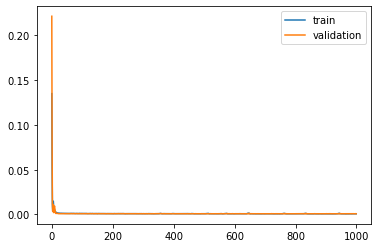

In [19]:
# membuat rancangan model
model = Sequential()
# bidirectinal layer
model.add(Bidirectional(LSTM(127, return_sequences=True),input_shape=(train_X.shape[1], train_X.shape[2])))
# fully connected layer
model.add(Flatten())
model.add(Dense(115, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(0.0005)
model.compile(loss='mse', optimizer= opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()
# pelatihan model
history = model.fit(train_X, train_y, batch_size= 350, epochs= 1000, validation_data=(valid_X, valid_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.savefig('M:/Metopen/save/loss_br.jpg', format='jpg', dpi=1000)
pyplot.legend()
pyplot.show()

In [20]:
history.history

{'loss': [0.1348275989294052,
  0.05346093326807022,
  0.011504413560032845,
  0.003796010510995984,
  0.012008314952254295,
  0.014879376627504826,
  0.009357704780995846,
  0.0052649215795099735,
  0.004622301086783409,
  0.005357456859201193,
  0.004209133330732584,
  0.002900342922657728,
  0.0026837331242859364,
  0.0025490960106253624,
  0.0026456653140485287,
  0.002268858253955841,
  0.0021079496946185827,
  0.001957068219780922,
  0.0017363827209919691,
  0.0016459141625091434,
  0.0015939802397042513,
  0.0016041123308241367,
  0.0014754708390682936,
  0.0015926340129226446,
  0.0015098382718861103,
  0.0014074998907744884,
  0.0014952216297388077,
  0.0013691720087081194,
  0.0014088648604229093,
  0.0013759416760876775,
  0.001307188649661839,
  0.0012851647334173322,
  0.0013807128416374326,
  0.0013160784728825092,
  0.001262171776033938,
  0.001283475081436336,
  0.001282369950786233,
  0.0012500548036769032,
  0.0014012372121214867,
  0.0013279839185997844,
  0.00133088

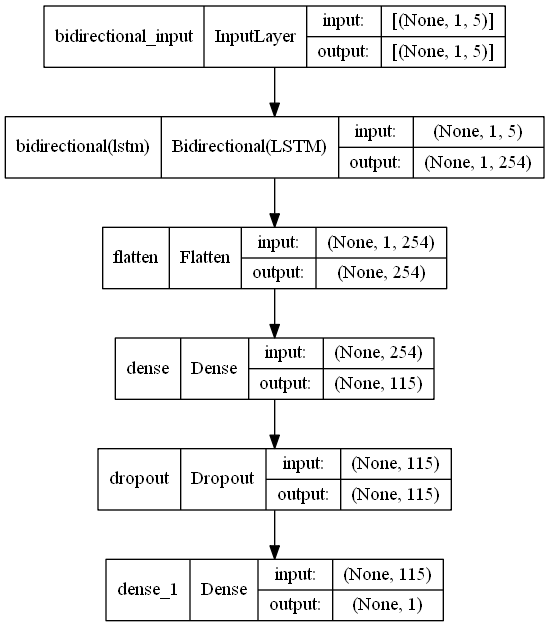

In [21]:
# plot model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='M:/Metopen/save/model_br.png', show_shapes=True, show_layer_names=True)

# Evaluasi Model

In [22]:
# evaluasi model dengan data pelatihan
evaluasi = model.evaluate(train_X, train_y)
print("train loss:", "train metrics:", evaluasi)

44/44 [==============================] - 0s 3ms/step - loss: 3.7037e-04 - root_mean_squared_error: 0.0192
train loss: train metrics: [0.0003703661495819688, 0.019244899973273277]


In [23]:
# evaluasi model dengan data pengujian
evaluasi = model.evaluate(test_X, test_y)
print("test loss:", "test metrics:", evaluasi)

6/6 [==============================] - 0s 0s/step - loss: 5.6672e-04 - root_mean_squared_error: 0.0238
test loss: test metrics: [0.00056671560741961, 0.023805789649486542]


In [24]:
model.save('M:/Metopen/save/model_bri.h5')
model.save_weights('M:/Metopen/save/model_weights_bri.h5')

# Prediksi Data

Prediksi menggunakan data dengan jangka waktu 22 desember 2021 sampai 31 Agustus 2022

In [25]:
# load model
model = load_model('M:/Metopen/save/model_bri.h5')
model.load_weights('M:/Metopen/save/model_weights_bri.h5')

# load data bank BRI baru
df = read_csv('stock_dataset/BBRI.JK_revisi.csv', parse_dates = True, index_col=0)
dataset = df.reset_index()

In [26]:
data = dataset.set_index('Date')
last_col = data.pop('Close')
type(last_col)
pd.core.series.Series
data.insert(loc=0, column = 'Close', value = last_col)
data

,Close,Open,High,Low,Adj Close
Date,,,,,
2021-12-22,4050,4100,4110,4050,3895.575684
2021-12-23,4100,4090,4110,4060,3943.669189
2021-12-24,4070,4100,4120,4050,3914.813232
2021-12-27,4060,4070,4110,4060,3905.194336
2021-12-28,4090,4090,4110,4070,3934.050537
...,...,...,...,...,...
2022-08-24,4290,4300,4330,4280,4290.000000
2022-08-25,4270,4280,4300,4270,4270.000000
2022-08-26,4270,4280,4290,4270,4270.000000


In [27]:
# normalisasi data uji baru
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

# konversi data uji baru
ref = series_to_supervised(scaled, 1, 1)
ref.drop(ref.columns[[6,7,8,9]], axis=1, inplace=True)
ref

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.011111,0.101124,0.022472,0.100000,0.000000,0.066667
2,0.066667,0.089888,0.022472,0.111111,0.046048,0.033333
3,0.033333,0.101124,0.033708,0.100000,0.018419,0.022222
4,0.022222,0.067416,0.022472,0.111111,0.009210,0.055556
5,0.055556,0.089888,0.022472,0.122222,0.036838,0.044444
...,...,...,...,...,...,...
160,0.288889,0.280899,0.247191,0.333333,0.387222,0.277778
161,0.277778,0.325843,0.269663,0.355556,0.377648,0.255556
162,0.255556,0.303371,0.235955,0.344444,0.358498,0.255556
163,0.255556,0.303371,0.224719,0.344444,0.358498,0.233333


In [28]:
# membuat dataset 
values = ref.values
new_test_X, new_test_y = values[:, :-1], values[:, -1]
new_test_X = new_test_X.reshape((new_test_X.shape[0], 1, new_test_X.shape[1]))
print(new_test_X.shape, new_test_y.shape)

(164, 1, 5) (164,)


In [29]:
# membuat prediksi dengan data yang baru 
predict = model.predict(new_test_X)
new_test_X = new_test_X.reshape((new_test_X.shape[0], new_test_X.shape[2]))
# denormalisasi untuk data prediksi
inv_predict = concatenate((predict, new_test_X[:, 1:]), axis=1)
inv_predict = scaler.inverse_transform(inv_predict)
inv_predict = inv_predict[:, 0]
# denormalisasi untuk data aktual
new_test_y = new_test_y.reshape((len(new_test_y), 1))
inv_actual = concatenate((new_test_y, new_test_X[:, 1:]), axis=1)
inv_actual = scaler.inverse_transform(inv_actual)
inv_actual = inv_actual[:,0]

In [30]:
# hasil prediksi sebelum denormalisasi
predict

array([[0.02681042],
       [0.07191949],
       [0.04426746],
       [0.04231889],
       [0.06682703],
       [0.05746665],
       [0.08520693],
       [0.15169661],
       [0.14734991],
       [0.18443927],
       [0.13884503],
       [0.17207894],
       [0.17135489],
       [0.12931605],
       [0.1389693 ],
       [0.17551307],
       [0.16519812],
       [0.19440535],
       [0.16333506],
       [0.11218194],
       [0.11185961],
       [0.14572999],
       [0.09917444],
       [0.02790546],
       [0.06216977],
       [0.11111195],
       [0.10919362],
       [0.04618169],
       [0.04438227],
       [0.11300281],
       [0.18966895],
       [0.38128158],
       [0.45441586],
       [0.45851678],
       [0.4809562 ],
       [0.44927454],
       [0.41135895],
       [0.432663  ],
       [0.42824244],
       [0.395335  ],
       [0.4315973 ],
       [0.49972242],
       [0.4445523 ],
       [0.49149674],
       [0.39084822],
       [0.54869956],
       [0.652943  ],
       [0.579

In [31]:
# hasil prediksi pada setiap langkah waktu
inv_test_X= scaler.inverse_transform(new_test_X)

for i in range(len(inv_test_X)):
    print("X=%s, Predicted= %s" % (inv_test_X[i], inv_predict[i]))

X=[4050.       4100.       4110.       4050.       3895.575684], Predicted= 4064.12938028574
X=[4100.       4090.       4110.       4060.       3943.669189], Predicted= 4104.727544039488
X=[4070.       4100.       4120.       4050.       3914.813232], Predicted= 4079.840714633465
X=[4060.       4070.       4110.       4060.       3905.194336], Predicted= 4078.086999207735
X=[4090.       4090.       4110.       4070.       3934.050537], Predicted= 4100.144326090813
X=[4080.       4090.       4100.       4070.       3924.431885], Predicted= 4091.7199836671352
X=[4110.       4080.       4140.       4060.       3953.288086], Predicted= 4116.686233282089
X=[4180.       4120.       4190.       4090.       4020.618896], Predicted= 4176.526946723461
X=[4160.       4200.       4210.       4160.       4001.381592], Predicted= 4172.61491805315
X=[4210.       4180.       4230.       4130.       4049.475098], Predicted= 4205.995344519615
X=[4160.       4240.       4240.       4140.       4001.38159

In [32]:
# menghitung nilai RMSE dan Mape
rmse = sqrt(mean_squared_error(inv_predict, inv_actual))
print('Test RMSE: %.2f' % rmse)
mape = np.mean(np.abs((inv_actual - inv_predict)/inv_actual))*100
print(f'Test MAPE: {np.round(mape, 2)} %')

Test RMSE: 74.82
Test MAPE: 1.2 %


In [33]:
# insert nilai tanggal, aktual, prediksi
test = dataset.drop(dataset.index[0])
test.insert(1, "Prediction", inv_predict.ravel(), True)
#test.insert(1, "Difference", test["Prediction"] - test["Actual"], True)

In [34]:
# perbandingan hasil pengujian dan prediksi
test = pd.DataFrame(test, columns = ["Date", "Close", "Prediction"])
test["RMSE"] = test.apply(lambda x: mean_squared_error(test.loc[:x.name, 'Close'].tolist(), test.loc[:x.name, 'Prediction'].tolist(), squared=False), axis = 1)
test["MAPE"] = test.apply(lambda x: np.mean(np.abs((test.loc[:x.name, 'Close'].tolist() - test.loc[:x.name, 'Prediction'])/test.loc[:x.name, 'Close'].tolist()))*100, axis=1)
test.to_csv("M:/Metopen/save/hasil_prediksi_br.csv", index=False)
print(test)

          Date  Close   Prediction       RMSE      MAPE
1   2021-12-23   4100  4064.129380  35.870620  0.874893
2   2021-12-24   4070  4104.727544  35.303709  0.864075
3   2021-12-27   4060  4079.840715  31.018047  0.738946
4   2021-12-28   4090  4078.086999  27.514892  0.627027
5   2021-12-29   4080  4100.144326  26.207141  0.600368
..         ...    ...          ...        ...       ...
160 2022-08-24   4290  4314.578381  75.603878  1.216586
161 2022-08-25   4270  4309.325382  75.432414  1.214750
162 2022-08-26   4270  4291.277629  75.217817  1.210328
163 2022-08-29   4250  4290.186747  75.052767  1.208704
164 2022-08-30   4260  4263.454189  74.824084  1.201828

[164 rows x 5 columns]


# Visualisasi Data

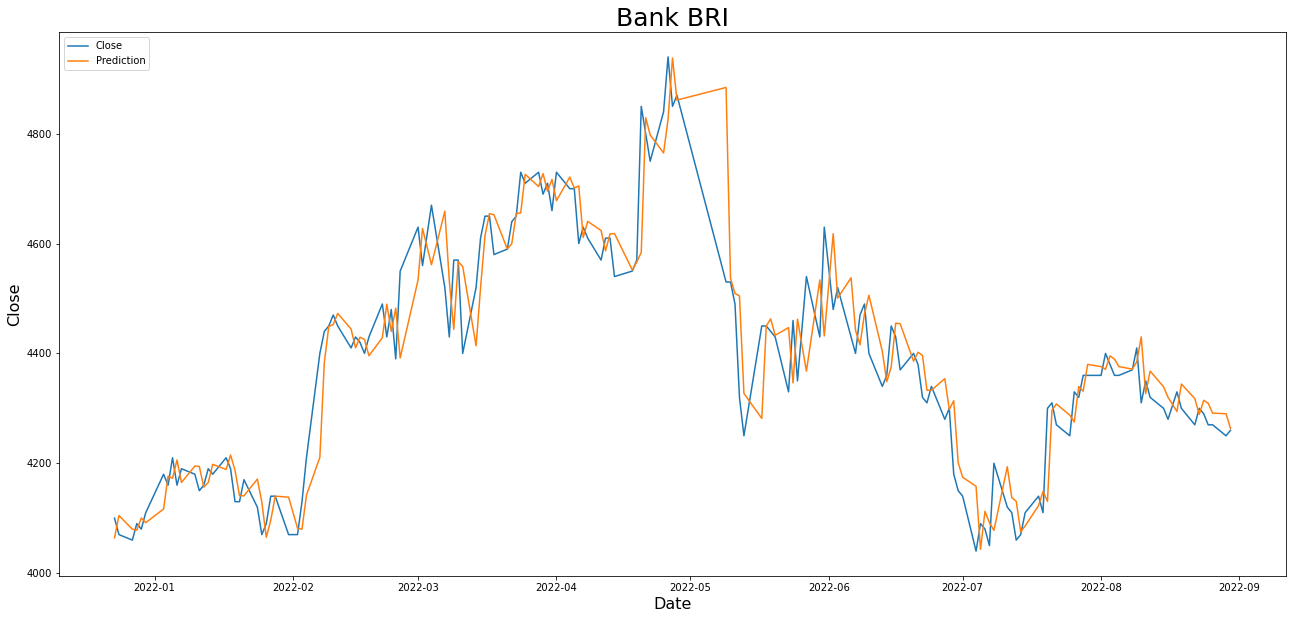

In [35]:
# visualisasi data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = test["Date"]
yt = test[["Close", "Prediction"]]
plt.title("Bank BRI", fontsize= 25)
plt.plot(xt, yt["Close"])
plt.ylabel("Close", fontsize= 16)
plt.xlabel("Date", fontsize= 16)
plt.plot(xt, yt["Prediction"])
plt.legend(["Close","Prediction"], loc="upper left")
plt.savefig('M:/Metopen/save/hasil_prediksi_br.jpg', format='jpg', dpi=1000)

#plt.grid()
plt.show()